<a href="https://colab.research.google.com/github/adinesia/PySparkProject/blob/main/Pyspark_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing pyspark on colab
!pip install pyspark

     |████████████████████████████████| 212.4MB 66kB/s 
     |████████████████████████████████| 204kB 15.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=8b697d466bebb9157cca475edbe04cb2ec5fbcd6e59e364a198052fe02f51aea
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [3]:
#Download dataset from github to colab
! git clone --recursive https://github.com/ashwanidv100/Kaggle--Data-Science-Problems/

Cloning into 'Kaggle--Data-Science-Problems'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.


In [4]:
# create sparkSession (like a container)
spark = SparkSession.builder.appName('Play with pyspark ML on titatic_dataset').getOrCreate()
# After creating spark, we use spark.read.csv to read dataset, like pandas.read_csv
df = spark.read.csv('/content/Kaggle--Data-Science-Problems/Problem Titanic- Machine Learning from Disaster/Datasets/train.csv',header = 'True',inferSchema='True')

In [5]:
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [6]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [7]:
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



For visualization, SparkDataframe need to convert to PandasDataFrame

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


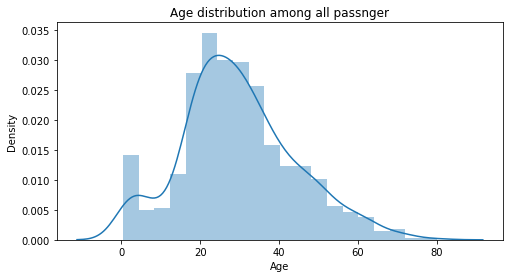

In [8]:
pandas_df = df.toPandas()

plt.figure(figsize=(8,4))
plt.title("Age distribution among all passnger")
sns.distplot(pandas_df.Age)

In [9]:
# Function to check null and nan
import pyspark.sql.functions as F
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [10]:
count_missings(df)

,count
Cabin,687
Age,177
Embarked,2
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
SibSp,0
Parch,0


In [11]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [12]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
df = df.drop("Cabin")

In [13]:
df = df.withColumn("Initial", regexp_extract(col('Name'), "([A-Za-z]+)\.",1))
df.limit(4).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [14]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [15]:
# Checking the average age by Initials
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [16]:
df = df.withColumn("Age", when((df["Initial"] == "Miss") & (df["Age"].isNull()),22).otherwise(df["Age"]))
df = df.withColumn("Age", when((df["Initial"] == "Other") & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master")  & (df["Age"].isNull()), 5).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")  & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))

In [17]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       2|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [18]:
# Embarked columns has two missing values, let check it
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [19]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
df = df.na.fill({"Embarked":'S'})
# Check again the missing value status
df.select([count(when(isnan(x) | col(x).isNull(),x)).alias(x) for x in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



After handling missing values, we do some simple feature engineering


in Feature engineering, we can use Pyspark multiple condition with syntax: "When otherwise"

In [20]:
df = df.withColumn("famili_size", col('SibSp')+col('Parch')) # create new column: family_size
df = df.withColumn('Alone', lit(0)) # create new column: Alone and assign 0 as defoult value
df = df.withColumn('Alone', when(df['famili_size'] == 0,1).otherwise(df['Alone']))

In [21]:
# converting sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

In [22]:
df.limit(4).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,famili_size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,0,1.0,0.0,2.0


In [23]:
# Now we drop columns that not needed for modelling
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

In [24]:
# before modelling in Pyspark, we need to put all features to Vector using Pyspark Vector Assembler
feature = VectorAssembler(inputCols = df.columns[1:], outputCol="features")
feature_vector = feature.transform(df)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,famili_size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."


In [25]:
# for data split in pyspark, we can use df.randomSplit()
(train_df, test_df) = feature_vector.randomSplit([0.8,0.2], seed=11)

In [26]:
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- famili_size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [27]:
# select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# split the dataset to train and test
train_df, test_df = titanic_df.randomSplit([0.75,0.25], seed=11)

In [28]:
def spark_shape(self):
    return (self.count(), len(self.columns))

In [29]:
spark_shape(titanic_df)

(891, 2)

In [30]:
# shape in spark
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.crossJoin.enabled", "true")
print(df.toPandas().shape)

(891, 11)


In [31]:
# load pyspark libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc


lr = LogisticRegression(labelCol="Survived")

# grid parameter
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# cross validation with parameter
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8626609442060086
Precision:  0.8619683825221875


Evaluating ROC metric

In [32]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.902292152292152


Visualizing AUC metrics

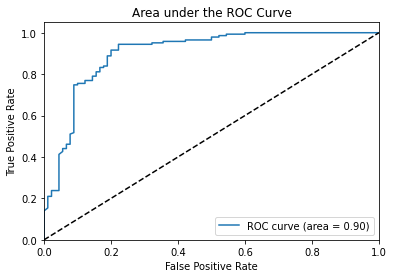

In [33]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

RANDOM FOREST

In [34]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8798283261802575
Precision:  0.8803297427697832


Evaluating ROC metrics

In [35]:
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.9102564102564104


Visualizing AUC metrics

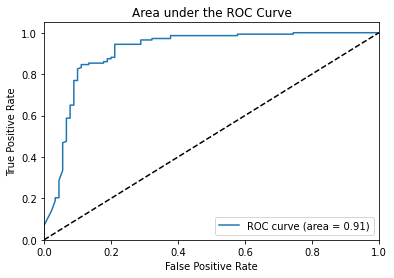

In [36]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()